In the presence of outliers, an alternative to the mean square loss is the Huber loss w.r.t. the residual $r=y-X\beta$ defined as follows
$$
\text{Huber}(r;M)=\left\{
\begin{aligned}
&r^2, &|r|<M \\
&2M|r|-M^2, &|r|\geq M .\\
\end{aligned}
\right.
$$
Here, we show an example to perform a Huber regression with ``scope``.

In [88]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from scope import ScopeSolver

import warnings
warnings.filterwarnings('ignore')

In [89]:
n, p = 500, 100
rng = np.random.default_rng(0)
X = rng.normal(0, 1, (n, p))
beta = np.zeros(p)
beta[0] = 2
y = X @ beta + rng.normal(0, 1, n)

# make outliers via flipping the sign of 20% response
fliplist = rng.random(len(y))
for i in range(len(y)):
    if fliplist[i] < 0.2:
        y[i] = - y[i]

In [90]:
def huber_loss(params):
    M = 0.1
    r = y - jnp.matmul(X, params)
    loss = jnp.sum(jnp.piecewise(r, 
                                 [(r>=-M)&(r<=M), r<-M, r>M], 
                                 [lambda r: r**2, lambda r: 2*M*jnp.abs(r)-M**2, lambda r: 2*M*jnp.abs(r)-M**2]
                    )
            )
    return loss

solver = ScopeSolver(p, sparsity=1)
params_huber = solver.solve(huber_loss)
print(np.nonzero(params_huber)[0])
print('Huber-Loss Error: ', np.sum((params_huber-beta)**2).round(3))

[0]
Huber-Loss Error:  0.063


In [91]:
def ols_loss(params):
    loss = jnp.mean((y - X @ params)**2)
    return loss

solver = ScopeSolver(p, sparsity=1)
params_ols = solver.solve(ols_loss)
print(np.nonzero(params_ols)[0])
print('Suqare-Loss Error: ', np.sum((params_ols-beta)**2).round(3))


[0]
Suqare-Loss Error:  0.593


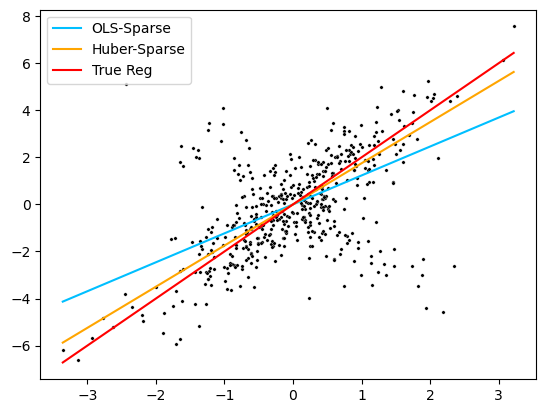

In [92]:
# visualize the regression functions
sns.scatterplot(x=X[:, 0], y=y, color='k', s=6)
sns.lineplot(x=X[:,0], y=params_ols[0]*X[:,0], color='deepskyblue', label='OLS-Sparse')
sns.lineplot(x=X[:,0], y=params_huber[0]*X[:,0], color='orange', label='Huber-Sparse')

sns.lineplot(x=X[:,0], y=2*X[:,0], color='red', label='True Reg')
plt.legend()
plt.show()